<a href="https://colab.research.google.com/github/RoyElkabetz/SEOP-and-NMR/blob/main/NMRG_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
np.random.seed(14)

In [3]:
# # Physical constants
# c = 1
# g129 = 1 #-74.4069*1e6       # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
# g131 = 1 #22.0564*1e6        # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html

# # unit conversions
# G2T = 1e-4                # Gauss to Tesla conversion. i.e. 5 Gauss * G2T = 5e-4 Tesla
# T2G = 1e4                 # Tesla to Gauss conversion. i.e. 5 Tesla * T2G = 5e4 Gauss

In [4]:
# # useful functions
# def l2_norm(a):
#   return np.sqrt(np.sum(np.power(a, 2)))

In [5]:
# # init a averaged spin
# K00 = np.random.randn(3)
# K00 /= l2_norm(K00)

# # set constant magnetic field
# Bx = 0
# By = 0
# Bz = 1
# B = np.array([[0, -Bz, By], 
#               [Bz, 0, -Bx], 
#               [-By, Bx, 0]])

# # world rotation in z
# w0 = 1  
# omega_r = np.array([[0, -w0, 0], 
#                     [w0, 0, 0], 
#                     [0, 0, 0]])

# # drive
# wd = 1
# omega_d = np.array([[0, 0, wd], 
#                     [0, 0, 0], 
#                     [-wd, 0, 0]]) / 2

# # set T1, T2
# T1 = 30     # s
# T2 = 8      # s
# Gamma = np.diag(1 / np.array([T2, T2, T1]))
# Gamma_se = 0.1 * 1/30              # Hz

# # Alkali spin
# S = np.array([0, 0, 1])

In [6]:
# # NMR dynamics equation
# def dK_dt(k, t):
#   Rse = Gamma_se * S
#   return -(g129 * np.matmul(B, k) + np.matmul(Gamma, k)) + np.matmul(omega_r, k) - np.matmul(omega_d, k) + Rse

In [7]:
# # solve ODE
# ts = np.linspace(0, 10, 10)
# K = odeint(dK_dt, K00, ts)
# K.shape

In [8]:
# # Plot the spin solution
# plt.rcParams.update({'font.size': 14})  # increase the font size
# plt.figure(figsize=(15, 8))
# plt.xlabel("t")
# plt.ylabel("$K$")
# plt.plot(ts, K[:, 0], label='$K_x$')
# plt.plot(ts, K[:, 1], label='$K_y$')
# plt.plot(ts, K[:, 2], label='$K_z$')
# plt.legend()
# plt.show()

# Single specie without magnetic noise simulation

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


In [15]:
class Xenon:
  def __init__(self, gamma, t1, t2, K0=np.array([0.05, 0, 0.95]), name='129'):
    
    self.name = name
    # Physical parameters
    self.gamma = gamma      # The xenon gyromagnetic ration   [rad  s^-1 T^-1] 
    
    # Decays
    self.t1 = t1            # T1 of xenon                     [s]
    self.t2 = t2            # T2 of xenon                     [s]
    self.gamma1 = 1. / t1   #                                 [s^-1]
    self.gamma2 = 1. / t2   #                                 [s^-1]
    
    # System parameters
    self.w0 = 0          # Larmor frequency                [rad  s^-1]
    self.wd_x = 0        # x drive frequency               [rad  s^-1]
    self.Ad_x = 0        # x drive amplitude               [s^-1]
    self.wd_y = 0        # y drive frequency               [rad  s^-1]
    self.Ad_y = 0        # y drive amplitude               [s^-1]
    
    # Spin polarization
    self.K = K0
    self.Rse = np.array([0, 0, 0])

    # Bloch matrix
    self.M = np.zeros((3, 3))

  def set_z_bias_field(self, B0):
    """Set z bias field"""
    self.w0 = self.gamma * B0

  def set_x_drive_field(self, drive_amplitude, drive_frequency):
    """Set NMR x drive"""
    assert (self.wd_y == 0 and self.Ad_y == 0)
    self.Ad_x = drive_amplitude
    self.wd_x = drive_frequency

  def set_y_drive_field(self, drive_amplitude, drive_frequency):
    """Set NMR y drive"""
    assert (self.wd_x == 0 and self.Ad_x == 0)
    self.Ad_y = drive_amplitude
    self.wd_y = drive_frequency

  def set_spin_exchange_amp(self, rse):
    """Set spin exchange pumping"""
    self.Rse = rse

  def set_bloch_matrix(self, wr):
    """Constructing the Bloch matrix of the dynamics"""
    M = np.array(
        [
          [-self.gamma2 , 0              , -self.Ad_y / 2],
          [0            , -self.gamma2   , self.Ad_x / 2 ],
          [self.Ad_y / 2, -self.Ad_x / 2., -self.gamma1  ] 
          ]
    )
    M12 = self.w0 + wr - self.wd_x - self.wd_y
    M[0, 1] = M12
    M[1, 0] = -M12
    self.M = M

  def bloch_equations(self, K, t):
    """Bloch dynamics model"""
    dK_dt = np.matmul(self.M, K) + self.Rse
    return dK_dt
  
  def solve_dynamics(self, ts):
    Kt = self.K
    Kt = odeint(self.bloch_equations, Kt, ts)
    return Kt

  def solve_steady_state(self):
    K_steady_state = -inv(self.M) @ self.Rse
    print(K_steady_state)



In [16]:
g129 = 1 #-74.4069*1e6       # rad  s^-1 T^-1 http://www.acadiau.ca/~bellis/resources/nmr/isotopes.html
t1 = 30     # s
t2 = 8      # s
B0 = 1
wr = 0
Ad = 0
wd = 0
Rse = np.array([0, 0, 1])

Xe129 = Xenon(gamma=g129, t1=t1, t2=t2, name='129')
Xe129.set_z_bias_field(B0)
Xe129.set_y_drive_field(Ad, wd)
Xe129.set_bloch_matrix(wr)
Xe129.set_spin_exchange_amp(Rse)

In [17]:
# solve ODE
ts = np.linspace(0, 1000, 100)
K = Xe129.solve_dynamics(ts)
K.shape

(100, 3)

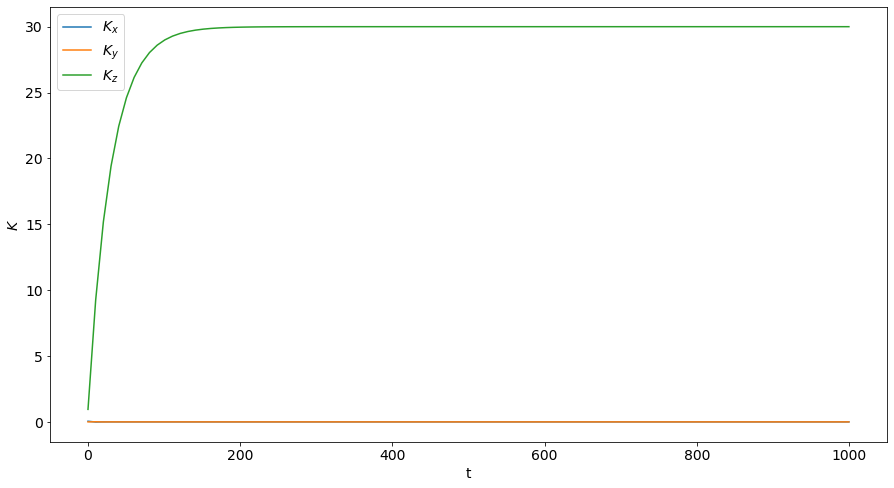

In [18]:
# Plot the spin solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.figure(figsize=(15, 8))
plt.xlabel("t")
plt.ylabel("$K$")
plt.plot(ts, K[:, 0], label='$K_x$')
plt.plot(ts, K[:, 1], label='$K_y$')
plt.plot(ts, K[:, 2], label='$K_z$')
plt.legend()
plt.show()

In [19]:
Xe129.solve_steady_state()

[ 0.  0. 30.]


In [20]:
K[-1, :]

array([ 7.81331025e-15, -2.61379598e-14,  3.00000000e+01])

In [21]:
Xe129.M

array([[-0.125     ,  1.        ,  0.        ],
       [-1.        , -0.125     ,  0.        ],
       [ 0.        ,  0.        , -0.03333333]])